# Houses Pricing - Random Forest Regression

**Importing libraries and the train dataset**

In [382]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [383]:
df = pd.read_csv('train.csv')

In [212]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [171]:
df.shape

(1460, 81)

### Searching for null/missing values 

In [384]:
nulls = pd.DataFrame(df.isnull().sum())

nulls[nulls[0] >0]

,0
LotFrontage,259
Alley,1369
MasVnrType,8
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


### Using a Heatmap to see the null/missing values

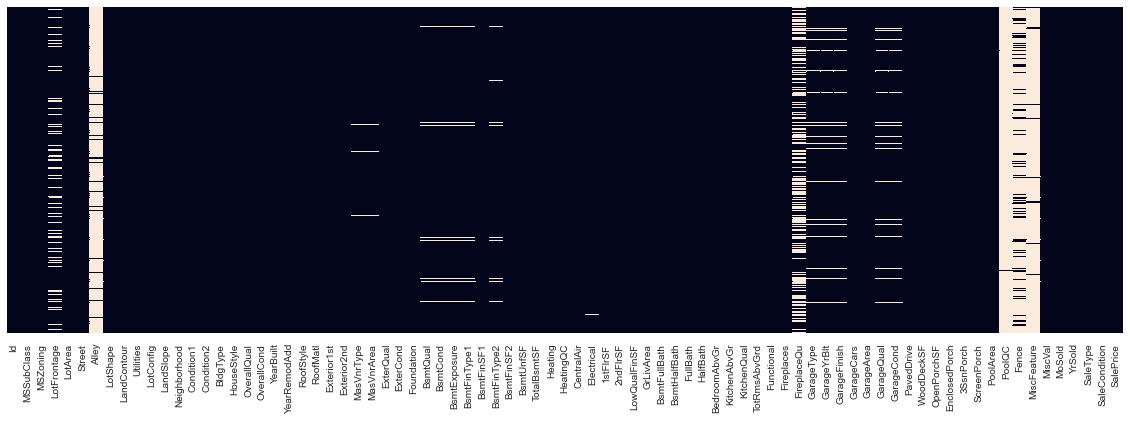

In [214]:
plt.figure(figsize=(20,6))
sns.heatmap(df.isnull(), cbar=False,yticklabels=False)

### Dropping columns with high number of null values

We will **drop the followed columns** where we have a high number of null values:

    * Alley
    * PoolQC
    * Fence
    * MiscFeature
    * FireplaceQu
    * LotFrontage
    
We can drop also the column **"Id"** because it will be irrelevant to the study


In [385]:
columns = ['Alley','PoolQC','Fence','MiscFeature','FireplaceQu','LotFrontage']
df.drop(columns, axis=1, inplace = True)

## Filling missing/null values 

### Column MasVnrType

In [216]:
df['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [386]:
df['MasVnrType'].fillna(value = 'None', inplace = True)

In [387]:
df['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn'], dtype=object)

### Column MasVnrArea

In [388]:
df.update(df['MasVnrArea'].fillna(value = 0, inplace = True))

## Column  BSMTQUAL 

In [389]:
df.update(df['BsmtQual'].fillna(value = 'NA', inplace = True))
df['BsmtQual'].unique()

array(['Gd', 'TA', 'Ex', 'NA', 'Fa'], dtype=object)

## Column BSMTCOND 

In [390]:
df.update(df['BsmtCond'].fillna(value = 'NA', inplace = True))
df['BsmtCond'].unique()

array(['TA', 'Gd', 'NA', 'Fa', 'Po'], dtype=object)

## Removing the basement data that is not crucial to the model

In [391]:
columns = ['BsmtExposure','BsmtFinType1','BsmtFinType2','GarageYrBlt','GarageType','GarageFinish','GarageQual','GarageCond']
df.drop(columns, axis=1, inplace = True)

## Removing the null values in ELECTRICAL category

In [392]:
df['Electrical'].isnull().sum()

1

In [393]:
df.update(df.Electrical.dropna(inplace= True))
df['Electrical'].unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'], dtype=object)

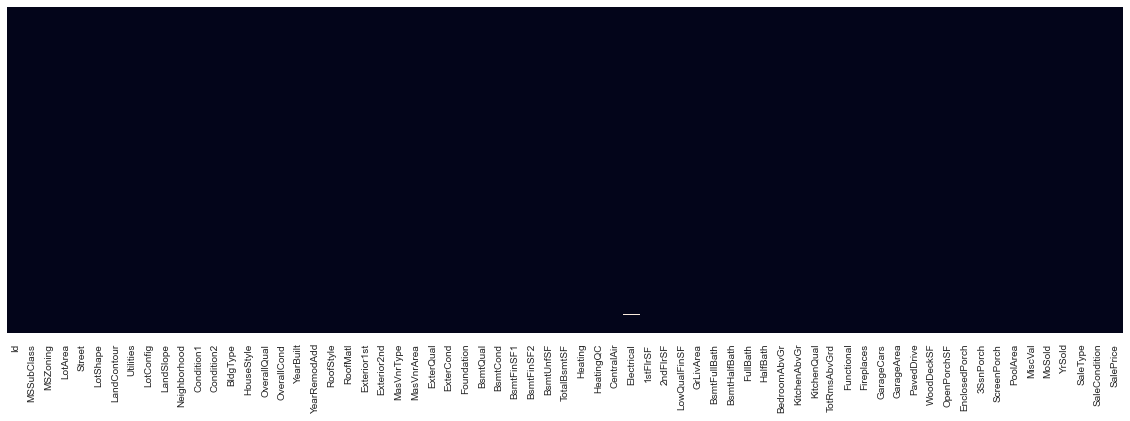

In [394]:
plt.figure(figsize=(20,6))
sns.heatmap(df.isnull(), cbar=False,yticklabels=False)

## Correlations with the target column - SalePrice

In [227]:
CorrTarget = df.corr()
CorrTarget['SalePrice']

Id              -0.021917
MSSubClass      -0.084284
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
SalePrice        1.000000
Name: SalePrice, dtype: float64

## Stracting the best correlations to the model - above 0.4

In [395]:
dicCorrelations = dict(CorrTarget['SalePrice'])
BestCorrelations = []

for k,v in dicCorrelations.items():
    if v >0.4:
        BestCorrelations.append(k)
    else:
        continue

In [396]:
BestCorrelations

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'SalePrice']

**We will pick up the best correlations with the Sale Price to analyse, they are:**
    
    OverallQual      0.790982
    YearBuilt        0.522897
    YearRemodAdd     0.507101
    MasVnrArea       0.477493
    TotalBsmtSF      0.613581
    1stFlrSF         0.605852
    GrLivArea        0.708624
    FullBath         0.560664
    TotRmsAbvGrd     0.533723
    TotRmsAbvGrd     0.533723
    Fireplaces       0.466929
    GarageYrBlt      0.486362
    GarageCars       0.640409
    GarageArea       0.623431

## Using a heatmap to visualize the correlations

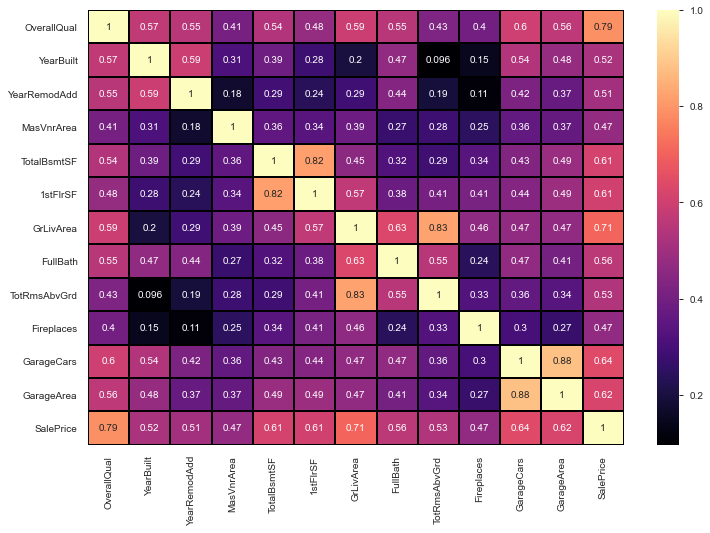

In [230]:
plt.figure(figsize=(12,8))
sns.heatmap(df[BestCorrelations].corr(),cmap = 'magma',annot = True, linecolor = 'black',lw = 1)

## Putting the best categories in another dataframe

In [397]:
df_bestcorr = df[BestCorrelations]
df_bestcorr.head(3)

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,SalePrice
0,7,2003,2003,196.0,856,856,1710,2,8,0,2,548,208500
1,6,1976,1976,0.0,1262,1262,1262,2,6,1,2,460,181500
2,7,2001,2002,162.0,920,920,1786,2,6,1,2,608,223500


# Starting the Regression model

**First, We separate the data in test and train**

In [401]:
from sklearn.model_selection import train_test_split

In [402]:
X_train,X_test,y_train,y_test = train_test_split(df_bestcorr.drop('SalePrice',axis=1), df_bestcorr['SalePrice'], test_size = 0.3)

**Reshaping the data**

In [403]:
y_train= y_train.values.reshape(-1,1)
y_test= y_test.values.reshape(-1,1)

**Importing the Random Forrest Regressor**

In [404]:
from sklearn.ensemble import RandomForestRegressor

In [405]:
model = RandomForestRegressor()

**Using the GridSearchCV to find the best parameters to the model**

In [406]:
from sklearn.model_selection import GridSearchCV

In [407]:
grid = GridSearchCV(model,parameters)

In [408]:
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [409]:
predictions = model.predict(X_test)
prediction = predictions.reshape(-1,1)

In [410]:
parameters = {'min_samples_leaf':[1,20], 'min_samples_split':[2,200],'n_estimators':[100,250,500,750,1000]}

In [411]:
grid.fit(X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_leaf': [1, 20], 'min_samples_split': [2, 200], 'n_estimators': [100, 250, 500, 750, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

**Getting the best parameters from the GridSearchCV**

In [246]:
grid.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}

In [247]:
best_model = grid.best_estimator_

**Predicting the houses price with the model**

In [412]:
predictions = best_model.predict(X_test)

**Let's see the dispersion of results between the predictions and the real data**

Text(0, 0.5, 'Predict')

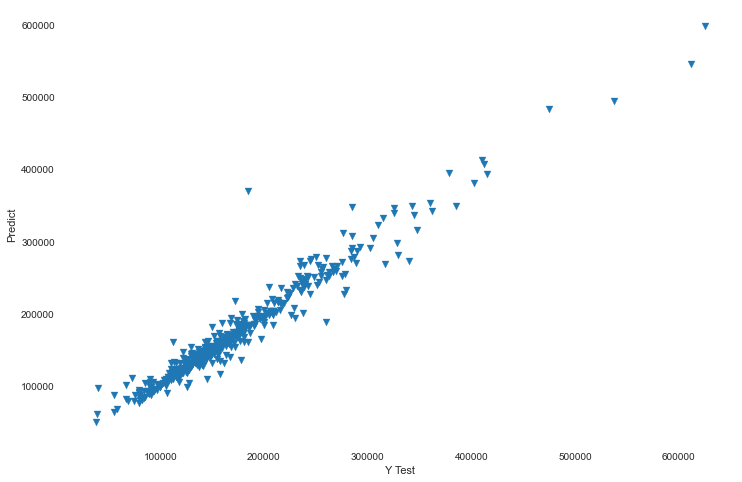

In [414]:
plt.figure(figsize=(12,8))
plt.scatter(y_test,predictions, marker = ('v'))
plt.xlabel('Y Test')
plt.ylabel('Predict')

In [415]:
error = y_test-predictions
error = error.reshape(-1,1)

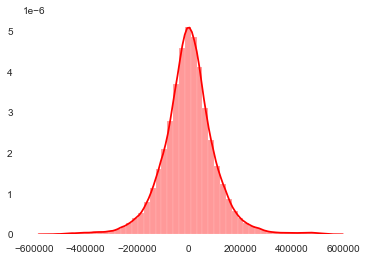

In [416]:
sns.distplot(error,bins=50, color = 'red')


## Comparing results

In [418]:
predictPrice = best_model.predict(df_bestcorr.drop('SalePrice',axis=1))
x = pd.DataFrame(predictPrice,columns=['SalePrice_Predicted'])

result_comparision = pd.concat([df,x], axis = 1)
result_comparision.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_Predicted
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,208500,203206.888
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,181500,175408.230
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,223500,222360.468
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,2,2006,WD,Abnorml,140000,154979.095
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,12,2008,WD,Normal,250000,290645.392


**Adding a column with the difference between the real price and the prediction**

In [343]:
result_comparision['Model_Error'] = result_comparision.SalePrice - result_comparision.SalePrice_Predicted

In [345]:
result_comparision[['SalePrice','SalePrice_Predicted','Model_Error']].head()

,SalePrice,SalePrice_Predicted,Model_Error
0,208500,203206.888,5293.112
1,181500,175408.230,6091.770
2,223500,222360.468,1139.532
3,140000,154979.095,-14979.095
4,250000,290645.392,-40645.392


## Now we can pass to the model the test dataset

In [357]:
BestCorrelations

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'SalePrice']

In [455]:
df_test = pd.read_csv('test.csv', usecols = 
                      [  'OverallQual',
                         'YearBuilt',
                         'YearRemodAdd',
                         'MasVnrArea',
                         'TotalBsmtSF',
                         '1stFlrSF',
                         'GrLivArea',
                         'FullBath',
                         'TotRmsAbvGrd',
                         'Fireplaces',
                         'GarageCars',
                         'GarageArea'])

In [456]:
df_test.isnull().sum()

OverallQual      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea      15
TotalBsmtSF      1
1stFlrSF         0
GrLivArea        0
FullBath         0
TotRmsAbvGrd     0
Fireplaces       0
GarageCars       1
GarageArea       1
dtype: int64

In [457]:
df_test.shape

(1459, 12)

**Clearing the data**

In [461]:
df_test.update(df_test['MasVnrArea'].fillna(value = 0, inplace = True))
df_test['TotalBsmtSF'].fillna(value = df_test.TotalBsmtSF.mean(), inplace = True)
df_test['GarageCars'].fillna(value = df_test.GarageCars.mean(), inplace = True)
df_test['GarageArea'].fillna(value = df_test.GarageArea.mean(), inplace = True)
df_test.isnull().sum()

OverallQual     0
YearBuilt       0
YearRemodAdd    0
MasVnrArea      0
TotalBsmtSF     0
1stFlrSF        0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
Fireplaces      0
GarageCars      0
GarageArea      0
dtype: int64

**Predicting results**

In [462]:
predict_result = best_model.predict(df_test)
predict_result = pd.DataFrame(predict_result,columns=['SalePrice'])

## Creating a Dataframe with the results predicted

In [463]:
index = pd.read_csv('test.csv')
Id = index['Id']
Id = pd.DataFrame(Id)

result = pd.concat([Id,predict_result.round(2)], axis =1)
result.head()

,Id,SalePrice
0,1461,123287.63
1,1462,124446.10
2,1463,175705.53
3,1464,182122.74
4,1465,192017.40


In [465]:
result.to_csv('submission.csv',index=False)

In [466]:
data  = pd.read_csv('submission.csv')

In [469]:
data.head()

,Id,SalePrice
0,1461,123287.63
1,1462,124446.10
2,1463,175705.53
3,1464,182122.74
4,1465,192017.40
